# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hnc_Ng import  HNC_solver
from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Function that sets up HNC QSP 

In [175]:
def set_hnc_onlyion(n_in_per_cc, T, Z, A, Zstar, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='kryov', add_bridge=False, bridge='yukawa',
            pseudopotential=False, r_c=0.6, no_coupling=False, N_bins = 500, R_max=5):
    
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, T, T, ri, Zstar*n_in_AU, which_Tij=which_Tij, r_c=r_c)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    
    rhos = np.array([  3/(4*np.pi)])
    temps = np.array([qsp.Ti])
    masses= np.array([qsp.m_i])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses ,
                     kappa_multiscale=5, R_max=R_max, N_bins=N_bins, 
                      names=names, dst_type=3, oz_method=oz_type)

    if pseudopotential==True:
        βvei = qsp.βvei_atomic(hnc1.r_array)
    else:
        βvei = qsp.βvei(hnc1.r_array)
    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array)]])
    if no_coupling:
        βu_r_matrix[0,1]=0
        βu_r_matrix[1,0]=0
    
    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()

    return hnc1, qsp

In [176]:
def set_hnc(n_in_per_cc, T, Z, A, Zstar, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='kryov', add_bridge=False, bridge='yukawa',
            pseudopotential=False, r_c=0.6, no_coupling=False, N_bins = 500, R_max=5):
    
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, T, T, ri, Zstar*n_in_AU, which_Tij=which_Tij, r_c=r_c)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = np.array([qsp.Ti, qsp.Te_c])
    masses= np.array([qsp.m_i, m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses ,
                     kappa_multiscale=10, R_max=R_max, N_bins=N_bins, 
                      names=names, dst_type=3, oz_method=oz_type)

    if pseudopotential==True:
        βvei = qsp.βvei_atomic(hnc1.r_array)
    else:
        βvei = qsp.βvei(hnc1.r_array)
    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), βvei],
                            [βvei, qsp.βvee(hnc1.r_array)]])
    if no_coupling:
        βu_r_matrix[0,1]=0
        βu_r_matrix[1,0]=0
    
    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()

    return hnc1, qsp

## Load TCCW Cases

In [409]:
mixture_file = "/home/zach/plasma/hnc/data/TCCW_single_species_data.csv"
tccw_mixture_data = read_csv(mixture_file)
tccw_cases = [tccw_mixture_data.iloc[n] for n in range(len(tccw_mixture_data))]

case_successes = {}
SVT_case_successes = {}
# R_max = 3
# N_bins = 100
max_attempts=1

tccw_case = tccw_cases[2]
α = 0.1
case_converged=False
case_attempts=0
case_num= tccw_case[' ']
case_id = tccw_case['Case ID']
ni = tccw_case['Number Density [N/cc]']
Te = tccw_case['Temperature [eV]']*eV
Ti = Te
Z = tccw_case['Atomic Number']
Zstar = tccw_case['Zbar (TFDW)']
A = tccw_case['Atomic Weight [a.u.]']
r_s = tccw_case['Wigner-Seitz Radius [cm]']
r_c = tccw_case['Average-Bound Radius [cm]']/r_s

print('\n______________________________\nCase num: {0} Case ID: {1}'.format(case_num, case_id))
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te/eV, ni, r_c))



______________________________
Case num: 2 Case ID: Al1
Te = 1.000e+00 eV, n_i = 6.030e+22 1/cc, r_c/r_s = 0.218


In [537]:
from scipy.optimize import minimize 

class c_s_k_fit():
    
    def __init__(self, fit_function, initial_guess):
        self.fit_function = fit_function
        self.guess = initial_guess
        self.get_vals()
        
    def err_of_f(self, params):
        return atom_onlyion.total_err(self.fit_function(params))
    
    def get_vals(self):
        sol = minimize(self.err_of_f, self.guess)
        self.fit_vals = sol.x
        self.err = sol.fun
    
    def csk_fit(self):
        return self.fit_function(self.fit_vals)
        
def c_s_k_sigmoid_cos_f(params):
    λ_rate, k_shift, A, κ, r_osc = params
    k = atom.k_array
    βu_k = atom_onlyion.βu_k_matrix
    c_k_initial_guess = -βu_k*1/(1+np.exp(λ_rate*(k-k_shift))) + A*np.exp(-κ*k)*np.cos(2*π*r_osc*k)
    c_s_k_initial_guess = c_k_initial_guess + atom_onlyion.βu_l_k_matrix
    return c_s_k_initial_guess

csk_fit1 = c_s_k_fit(c_s_k_sigmoid_cos_f, (3,2,2e2, 0.5,1/7)) #minimize(c_s_k_initial_guess_f,(1,2,1,1)
csk_fit1.fit_vals, csk_fit1.err

/tmp/ipykernel_31044/4118605819.py:25: RuntimeWarning: overflow encountered in exp
  c_k_initial_guess = -βu_k*1/(1+np.exp(λ_rate*(k-k_shift))) + A*np.exp(-κ*k)*np.cos(2*π*r_osc*k)
/tmp/ipykernel_31044/4118605819.py:25: RuntimeWarning: overflow encountered in exp
  c_k_initial_guess = -βu_k*1/(1+np.exp(λ_rate*(k-k_shift))) + A*np.exp(-κ*k)*np.cos(2*π*r_osc*k)


(array([4.07874950e+00, 1.20300679e+00, 1.38390748e+03, 7.23732549e-01,
        1.44015712e-01]),
 1.5148320391960886)

In [437]:
%%time
atom_onlyion, _ = set_hnc_onlyion(ni, Te, Z, A, Zstar, 
                            pseudopotential=True, oz_type='svt',r_c=r_c, 
                            add_bridge=True, bridge='ocp', N_bins=500, R_max=5)
c_k_initial_guess = -atom_onlyion.βu_k_matrix[0,0]*1/(1+np.exp(2.91575502*(atom.k_array-2)))
atom_onlyion.c_s_k_matrix[0,0] = c_k_initial_guess + atom_onlyion.βu_l_k_matrix[0,0] 

atom_onlyion.HNC_solve(alpha_method='fixed', alpha_Picard = 1e-1, tol=1e-8, alpha_Ng=0.1, 
               iters_to_wait=1e3, iters_to_use=2, num_iterations=20, verbose=True)

# options={'eps':1e-6,'maxfev':1000,'factor':1,'xtol':1e-3} 
# newton_kwargs= {'method':'hybr', 'options':options} 
# sol = atom_onlyion.HNC_newton_solve( **newton_kwargs)
# print("Err: ", atom_onlyion.total_err(atom_onlyion.FT_k_2_r_matrix(sol.x.reshape(1,1,500))))


Λei = 0.231
Λee = 0.326
Λei adjusted with R = 0.231
Γii=62.909, Γie=-2.630, Γee=1.000 
r_i=2.989
r_e=2.166
r_c=0.218
θ  =9.36e-02
0: Initial condition Total Error: 2.432e+01
1: Change in c_r: 7.502e+00, HNC Error: 1.398e+58, Total Error: 2.567e+01


<timed exec>:4: RuntimeWarning: overflow encountered in exp
/home/zach/plasma/hnc/hnc_Ng.py:561: RuntimeWarning: overflow encountered in exp
  hnc_err = np.linalg.norm(- 1 - self.h_r_matrix   + np.exp( -self.βu_r_matrix + self.h_r_matrix - self.c_r_matrix ))/np.sqrt(self.N_bins*self.N_species**2)
/home/zach/plasma/hnc/hnc_Ng.py:323: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc_Ng.py:421: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )
/home/zach/plasma/hnc/hnc_Ng.py:447: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)


2: Change in c_r: 1.007e+01, HNC Error: inf, Total Error: 3.410e+08
3: Change in c_r: 4.859e+01, HNC Error: inf, Total Error: inf
4: Change in c_r: 4.369e+02, HNC Error: inf, Total Error: inf
5: Change in c_r: 1.462e+03, HNC Error: inf, Total Error: inf
6: Change in c_r: 9.013e+02, HNC Error: inf, Total Error: inf
7: Change in c_r: 9.013e+02, HNC Error: inf, Total Error: inf
8: Change in c_r: 8.956e+02, HNC Error: inf, Total Error: inf
9: Change in c_r: 8.956e+02, HNC Error: inf, Total Error: inf
10: Change in c_r: 8.956e+02, HNC Error: inf, Total Error: inf
11: Change in c_r: 8.956e+02, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Exiting, reverting to best index so far:  0
Final iter:11, Total Error: 2.567e+01
CPU times: user 1.25 s, sys: 8.28 ms, total: 1.26 s
Wall time: 1.26 s


/home/zach/plasma/hnc/hnc_Ng.py:569: RuntimeWarning: invalid value encountered in subtract
  Δ_err = np.array(self.tot_err_list[-iters_to_check:-2]) - np.array(self.tot_err_list[-iters_to_check + 1:-1])


1

/tmp/ipykernel_31044/4118605819.py:25: RuntimeWarning: overflow encountered in exp
  c_k_initial_guess = -βu_k*1/(1+np.exp(λ_rate*(k-k_shift))) + A*np.exp(-κ*k)*np.cos(2*π*r_osc*k)


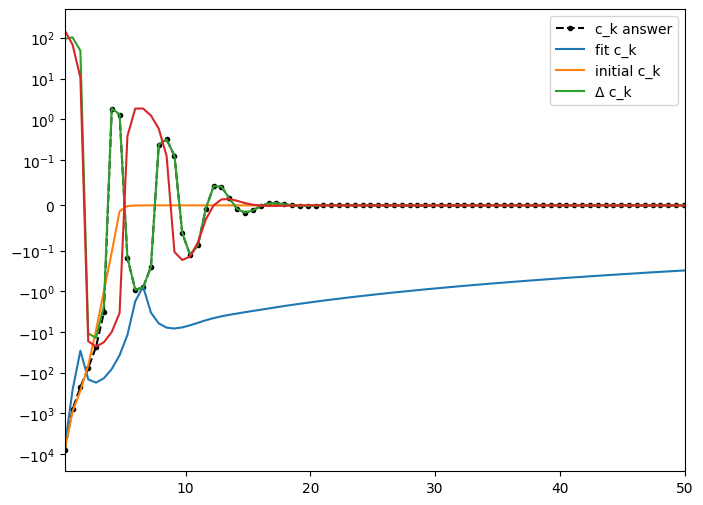

In [540]:
_,_,_,_,_,_,_,h_r_Ng,_, = atom_lowres.get_all_matrices_from_csk(atom_lowres.Ng_guess_c_s_k)

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.set_xlim(3e-1,50)
# ax.set_xscale('log')
ax.set_yscale('symlog',linthresh=0.1)
ax.plot(atom.k_array, atom_onlyion_answer.c_k_matrix[0,0],'k--.', label='c_k answer')
# ax.plot(atom.k_array, atom_onlyion_answer.c_s_k_matrix[0,0],'k-', label='c_s_k answer')
# ax.plot(atom.k_array, (-atom_onlyion_answer.βu_k_matrix[0,0]*1/(1+np.exp(1*(atom.k_array-5))) ), label='fit guess')
# ax.plot(atom.k_array, atom_onlyion.c_s_k_matrix[0,0], label='start')
ax.plot(atom.k_array, -atom_onlyion.βu_k_matrix[0,0]+csk_fit1.csk_fit()[0,0]  ,label='fit c_k')
ax.plot(atom.k_array, c_k_initial_guess  ,label='initial c_k')
ax.plot(atom.k_array, atom_onlyion_answer.c_k_matrix[0,0]-c_k_initial_guess  ,label='Δ c_k')
ax.plot(atom.k_array, 2e2*np.exp(-0.7*atom.k_array)*np.cos(2*π*(atom.k_array)/7))

# ax.plot(atom.k_array, atom_onlyion.βu_l_k_matrix[0,0]  ,label='βu_l')
# ax.plot(atom.k_array, c_k_initial_guess + atom_onlyion.βu_l_k_matrix[0,0],label='initial c_s_k')
# ax.plot(atom.k_array, atom_onlyion.βu_k_matrix[0,0], label='start')
# ax.plot(atom_onlyion.k_array, atom_onlyion.Ng_guess_c_s_k[0,0],'--',color=colors[0], label='Ng only ion guess' )
# ax.plot(atom_onlyion.k_array, atom_onlyion.c_s_k_matrix_list[-1][0,0],'--',color=colors[1] ,label='only ion -1' )
# ax.plot(atom_onlyion.k_array, atom_onlyion.c_s_k_matrix_list[-2][0,0],'--', color=colors[2],label='only ion -2' )
# ax.plot(atom_onlyion.k_array, atom_onlyion.c_s_k_matrix_list[-3][0,0],'--', color=colors[3],label='only ion -3' )
# ax.plot(atom_onlyion.k_array, atom_onlyion.c_s_k_matrix_list[-4][0,0],'--', color=colors[4],label='only ion -4' )
# ax.plot(atom_onlyion.k_array, atom_onlyion.c_s_k_matrix_list[-5][0,0],'--', color=colors[5],label='only ion -5' )
ax.legend()

Properties of good initial c_k guess
Polynomial at k<2, then exponential, asymptoting to zero around k=5-20

# Make atom

In [51]:
# %%time
# atom, atomqsp = set_hnc(ni, Te, Z, A, Zstar, 
#                             pseudopotential=True, oz_type='svt',r_c=r_c, 
#                             add_bridge=True, bridge='ocp', N_bins=500, R_max=5)
# atom.HNC_solve(alpha_method='fixed', alpha_Picard = 1, tol=1e-8, alpha_Ng=0, 
#                iters_to_wait=1e4, iters_to_use=2, num_iterations=1e3, verbose=True)

# options={'eps':1e-6,'maxfev':10000,'factor':100,'xtol':1e-8} 
# newton_kwargs= {'method':'hybr', 'options':options} 
# sol = atom.HNC_newton_solve( **newton_kwargs)



Root Finder:  True The solution converged.


In [103]:
# atom_onlyion_answer = atom_onlyion

In [137]:
%%time
atom_onlyion, _ = set_hnc_onlyion(ni, Te, Z, A, Zstar, 
                            pseudopotential=True, oz_type='svt',r_c=r_c, 
                            add_bridge=True, bridge='ocp', N_bins=500, R_max=5)

atom_onlyion.HNC_solve(alpha_method='fixed', alpha_Picard = 1, tol=1e-8, alpha_Ng=0.1, 
               iters_to_wait=1e1, iters_to_use=5, num_iterations=0, verbose=True)



Λei = 0.353
Λee = 0.500
Λei adjusted with R = 0.353
Γii=861.404, Γie=-0.235, Γee=0.239 
r_i=0.305
r_e=0.306
r_c=0.525
θ  =1.87e-04
0: Initial condition Total Error: 2.540e+03
1: Change in c_r: 1.472e+00, HNC Error: 4.509e+24, Total Error: 8.436e+02
Exiting, reverting to best index so far:  0
Final iter:1, Total Error: 8.436e+02
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 195 ms


1

In [120]:
atom_lowres, atomqsp = set_hnc(ni, Te, Z, A, Zstar, 
                            pseudopotential=True, oz_type='svt',r_c=r_c, 
                            add_bridge=True, bridge='ocp', N_bins=500, R_max=5)
# atom_lowres.c_s_k_matrix[0,0] = atom.c_s_k_matrix[0,0]
atom_lowres.HNC_solve(alpha_method='fixed', alpha_Picard = 1e-1, tol=1e-3, alpha_Ng=0.1, 
               iters_to_wait=1e1, iters_to_use=5, num_iterations=12, verbose=True)

c_s_k_guess = atom_lowres.c_s_k_matrix.copy()

Λei = 0.231
Λee = 0.326
Λei adjusted with R = 0.231
Γii=62.909, Γie=-2.630, Γee=1.000 
r_i=2.989
r_e=2.166
r_c=0.218
θ  =9.36e-02
0: Initial condition Total Error: 1.407e+02
1: Change in c_r: 3.748e-02, HNC Error: 1.752e+03, Total Error: 1.288e+02
2: Change in c_r: 3.693e-02, HNC Error: 8.035e+01, Total Error: 1.179e+02
3: Change in c_r: 3.643e-02, HNC Error: 1.095e+01, Total Error: 1.079e+02
4: Change in c_r: 3.598e-02, HNC Error: 2.679e+00, Total Error: 9.871e+01
5: Change in c_r: 3.555e-02, HNC Error: 8.990e-01, Total Error: 9.031e+01
6: Change in c_r: 3.514e-02, HNC Error: 3.477e-01, Total Error: 8.263e+01
7: Change in c_r: 3.476e-02, HNC Error: 1.343e-01, Total Error: 7.559e+01
8: Change in c_r: 3.440e-02, HNC Error: 5.298e-02, Total Error: 6.916e+01
9: Change in c_r: 3.405e-02, HNC Error: 5.476e-02, Total Error: 6.328e+01
Starting Ng loop, using best index so far:  8
 α matrix,  [[[-219964.36209488  320948.71735382 -208370.46709061   50786.27064419]
  [ -10370.39110374   12750.95

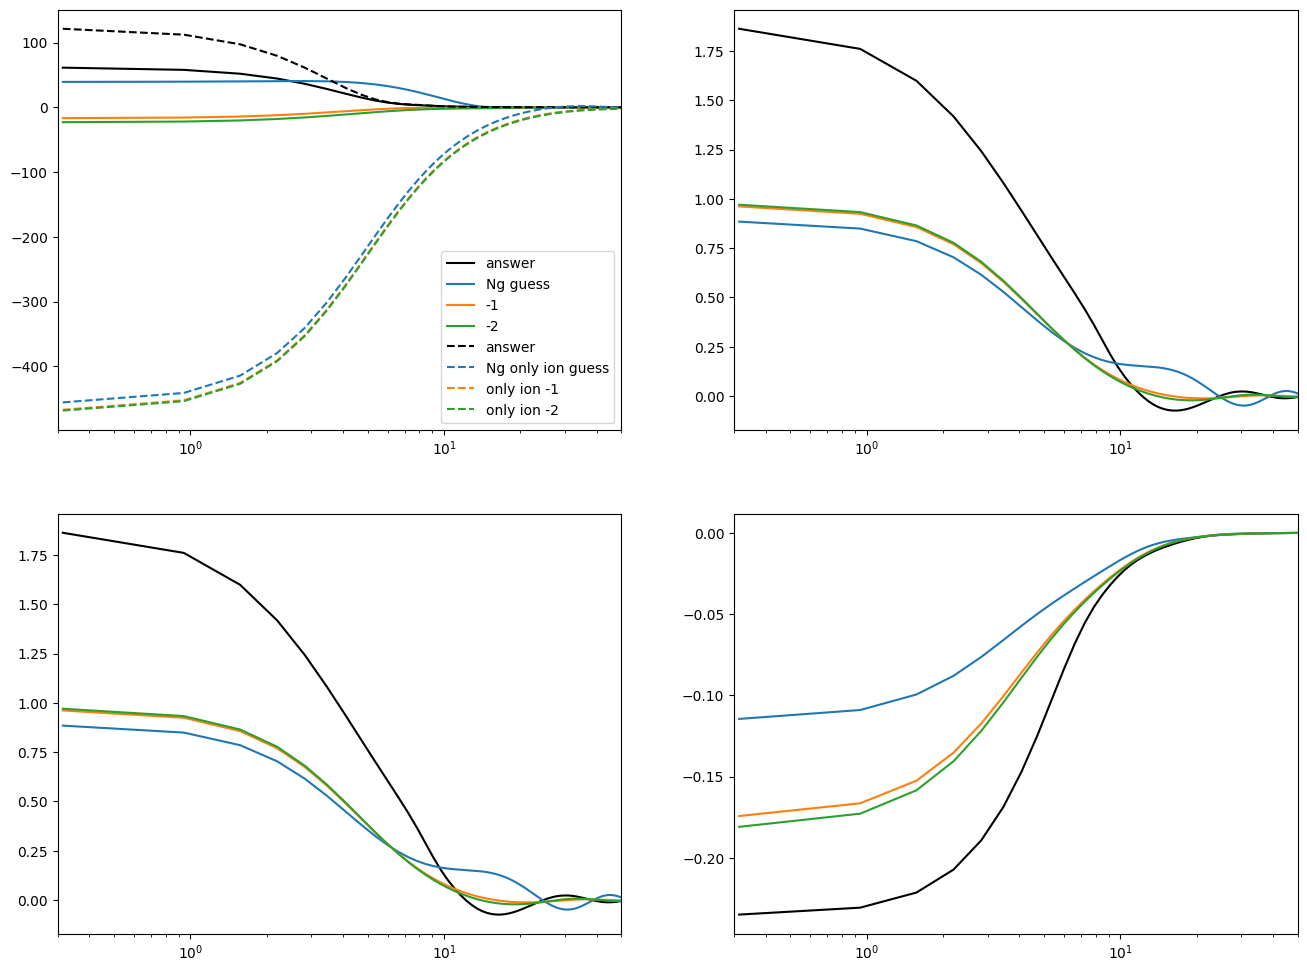

In [129]:
_,_,_,_,_,_,_,h_r_Ng,_, = atom_lowres.get_all_matrices_from_csk(atom_lowres.Ng_guess_c_s_k)

fig, axs = plt.subplots(2,2, figsize=(16,12))

for i in range(2):
        for j in range(2):
#             axs[i,j].plot(atom_lowres.r_array, h_r_Ng[i,j])
            axs[i,j].plot(atom.k_array, atom.c_s_k_matrix[i,j],'k-', label='answer')
            axs[i,j].plot(atom_lowres.k_array, atom_lowres.Ng_guess_c_s_k[i,j],'-',label='Ng guess')
            axs[i,j].plot(atom_lowres.k_array, atom_lowres.c_s_k_matrix_list[-1][i,j],label='-1')
            axs[i,j].plot(atom_lowres.k_array, atom_lowres.c_s_k_matrix_list[-2][i,j],label='-2')
            axs[i,j].set_xlim(3e-1,50)
            axs[i,j].set_xscale('log')
axs[0,0].plot(atom.k_array, atom_onlyion_answer.c_s_k_matrix[0,0],'k--', label='answer')
axs[0,0].plot(atom_onlyion.k_array, atom_onlyion.Ng_guess_c_s_k[0,0],'--',color=colors[0], label='Ng only ion guess' )
axs[0,0].plot(atom_onlyion.k_array, atom_onlyion.c_s_k_matrix_list[-1][0,0],'--',color=colors[1] ,label='only ion -1' )
axs[0,0].plot(atom_onlyion.k_array, atom_onlyion.c_s_k_matrix_list[-2][0,0],'--', color=colors[2],label='only ion -2' )
axs[0,0].legend()

In [9]:
%%time
atom_lowres.c_s_k_matrix = c_s_k_guess.copy()
options={'eps':1e-6,'maxfev':10000,'factor':100,'xtol':1e-4} 
newton_kwargs= {'method':'hybr', 'options':options} 
sol = atom_lowres.HNC_newton_solve( **newton_kwargs)


/home/zach/plasma/hnc/hnc_Ng.py:309: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )



Root Finder:  False The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
CPU times: user 7.66 s, sys: 8.08 ms, total: 7.66 s
Wall time: 7.67 s


In [42]:
print("Err: ", atom_lowres.total_err(atom_lowres.FT_k_2_r_matrix(sol.x.reshape(2,2,100))))
c_s_k_afterhybr = atom_lowres.c_s_k_matrix.copy()

Err:  0.0182415121650835


In [127]:
from scipy.interpolate import interp1d
atom_highres, atomqsp = set_hnc(ni, Te, Z, A, Zstar, 
                            pseudopotential=True, oz_type='svt',r_c=r_c, 
                            add_bridge=True, bridge='ocp', N_bins=400, R_max=3)

for i in range(2):
    for j in range(2):
#         atom_highres.c_s_k_matrix[i,j] = interp1d(atom_lowres.k_array, c_s_k_afterhybr[i,j], bounds_error=False, 
#                             fill_value=(c_s_k_afterhybr[i,j,0], 0), kind='quadratic')(atom_highres.k_array)
        atom_highres.c_s_r_matrix[i,j] = interp1d(atom_lowres.r_array, atom_lowres.FT_k_2_r(c_s_k_afterhybr[i,j]), bounds_error=False, 
                            fill_value=(atom_lowres.FT_k_2_r(c_s_k_afterhybr[i,j])[0], 0), kind='quadratic')(atom_highres.r_array)
        atom_highres.c_s_k_matrix[i,j] = atom_highres.FT_k_2_r(atom_highres.c_s_r_matrix[i,j])

# atom_highres.HNC_solve(alpha_method='fixed', alpha_Picard = 1e-3, tol=1e-3, alpha_Ng=1e-10, 
#                iters_to_wait=1e4, num_iterations=1e3)

c_s_k_high_guess = atom_highres.c_s_k_matrix.copy()
print("Guess Err: ", atom_highres.total_err(atom_highres.FT_k_2_r_matrix(c_s_k_high_guess)))

Λei = 0.186
Λee = 0.263
Λei adjusted with R = 0.186
Γii=301.565, Γie=-3.156, Γee=0.580 
r_i=2.667
r_e=1.517
r_c=0.199
θ  =4.59e-02
Guess Err:  inf


In [128]:
# %%time
# # atom_highres.c_s_k_matrix = c_s_k_high_guess.copy()
# options={'eps':1e-6,'maxfev':10000,'factor':100,'xtol':1e-4} 
# newton_kwargs= {'method':'hybr', 'options':options} 
# high_sol = atom_highres.HNC_newton_solve( **newton_kwargs)
# print("Err: ", atom_highres.total_err(atom_highres.FT_k_2_r_matrix(high_sol.x.reshape(2,2,400))))
# # c_s_k_afterhigh = atom_highres.c_s_k_matrix.copy()
# c_s_k_afterhigh2 = atom_highres.c_s_k_matrix.copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


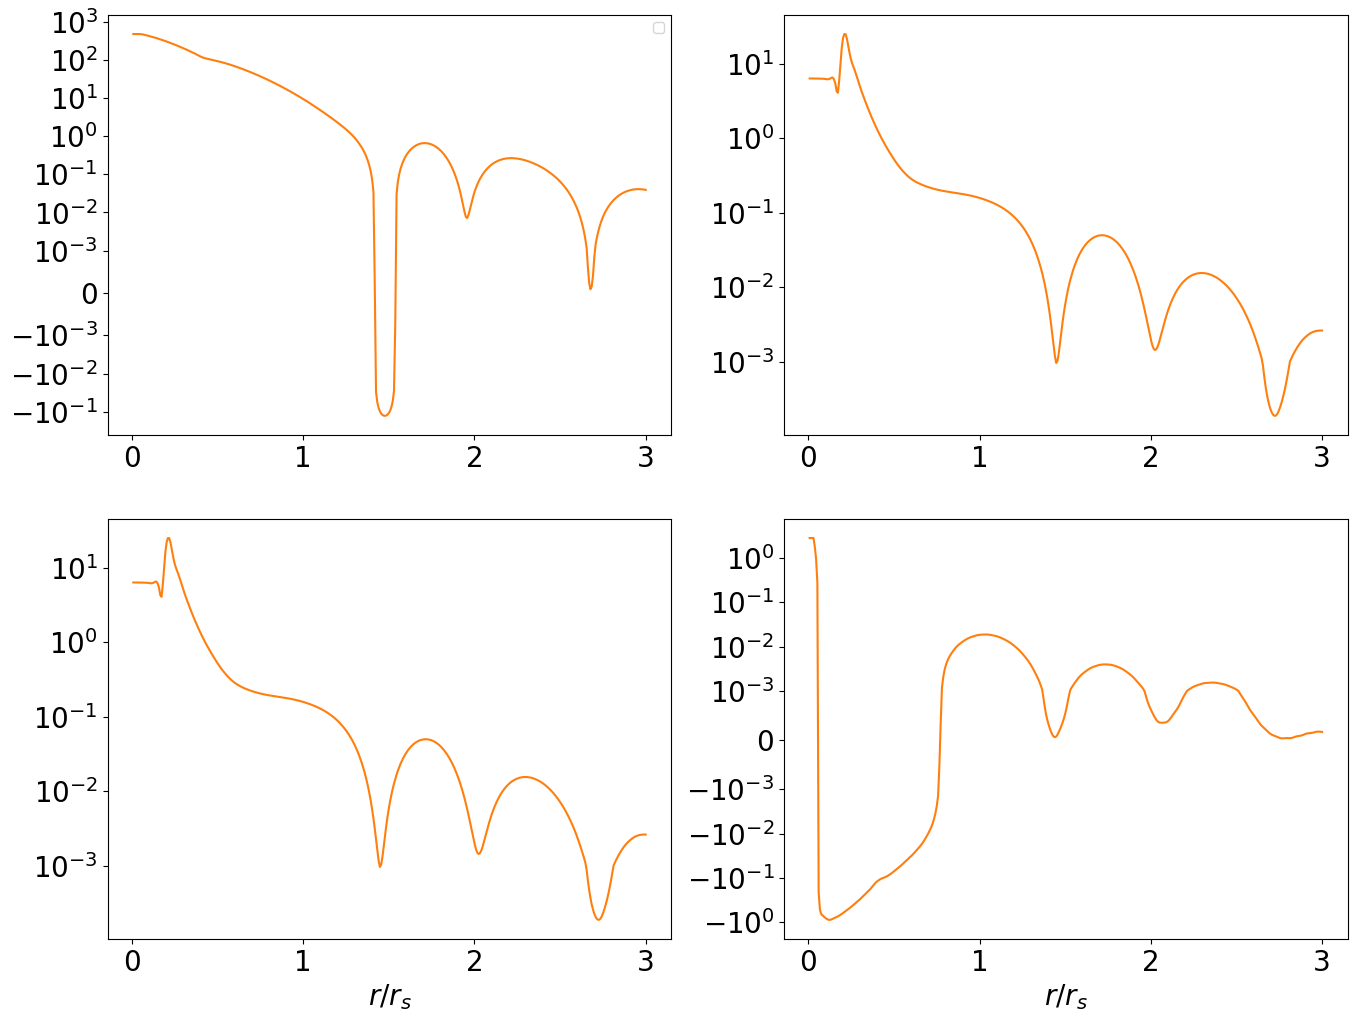

In [131]:
fig, axs = plt.subplots(2,2, figsize=(16,12))

for i in range(2):
        for j in range(2):
#             axs[i,j].plot(atom_lowres.k_array, atom_lowres.get_hnc_oz_matrix(c_s_k_afterhybr)[i,j],'--',color=colors[0])
#             axs[i,j].plot(atom_highres.k_array, atom_highres.get_hnc_oz_matrix(c_s_k_high_guess)[i,j],'--',color=colors[1])
#             axs[i,j].plot(atom_lowres.k_array, c_s_k_afterhybr[i,j],'.',color=colors[0])
#             axs[i,j].plot(atom_highres.k_array,c_s_k_high_guess[i,j],'-',color=colors[1])
            
#             axs[i,j].plot(atom_lowres.r_array, atom_lowres.get_hnc_oz_matrix(c_s_k_afterhybr)[i,j],'--',color=colors[0])
#             axs[i,j].plot(atom_highres.r_array, atom_highres.get_hnc_oz_matrix(c_s_k_high_guess)[i,j],'--',color=colors[1])
#             axs[i,j].plot(atom_lowres.r_array, c_s_k_afterhybr[i,j],'.',color=colors[0])
            axs[i,j].plot(atom_highres.r_array,  atom_highres.c_s_r_matrix[i,j],'-',color=colors[1])
            
            
            #             axs[i,j].plot(atom_lowres.k_array, sol.x.reshape(2,2,100)[i,j],'-',label='hybr')
#             axs[i,j].plot(atom_lowres.k_array, c_s_k_guess[i,j],'k.',label='Picard')
#             axs[i,j].plot(atom_highres.k_array, c_s_k_high_guess[i,j],'b--',label='Guess')
#             axs[i,j].plot(atom_highres.k_array, c_s_k_afterhigh[i,j],'r--',label='High Res')
#             axs[i,j].plot(atom_highres.k_array, c_s_k_afterhigh2[i,j],'r--',label='High Res')
            
#             axs[i,j].plot(atom_lowres.r_array, atom_lowres.c_s_r_matrix[i,j],label='Al no e')
            
            axs[i,j].tick_params(labelsize=20)
#             axs[i,j].set_xscale('log')
#             axs[i,j].set_xlim(0,50)
            axs[i,j].tick_params(labelsize=20)
            axs[-1,j].set_xlabel(r"$r/r_s $",fontsize=20)
            axs[i,j].set_yscale('symlog',linthresh=0.001)
#             axs[i,j].set_ylim(-10, 1e1)

#         axs[i,0].set_ylabel(r"$c(k)$",fontsize=20)
axs[0,0].legend()

In [83]:
Al_file = "/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt"  # 1 eV
Al_file = '/home/zach/plasma/datasets/RDFs/Al_0.5eV_rs3_KS-MD.txt' # 0.5 eV
Al_data = read_csv(Al_file,header=0, names=['r','g'])

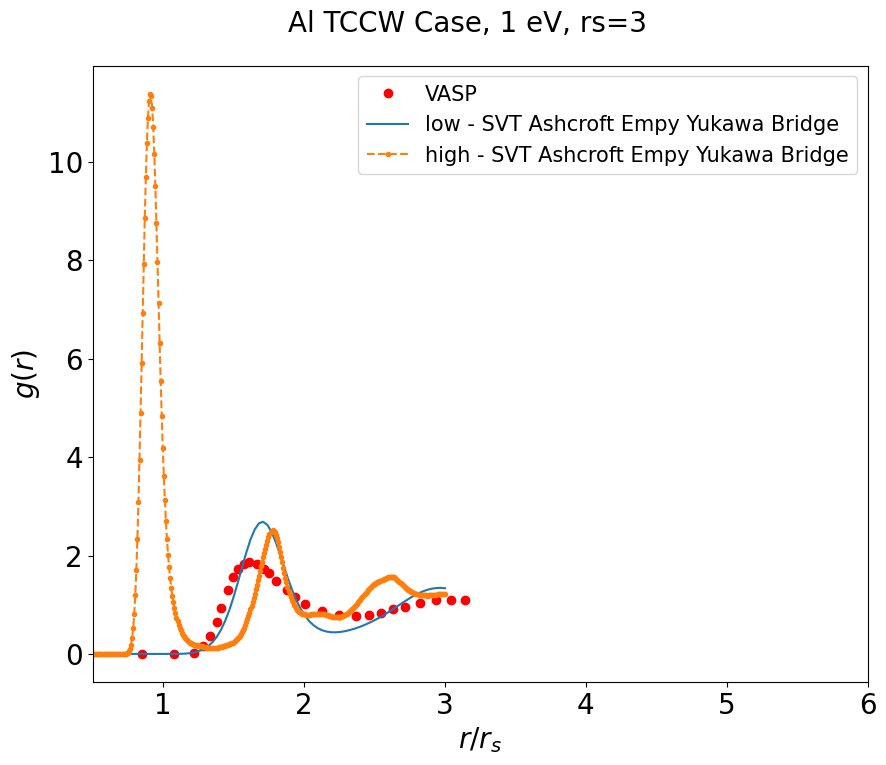

In [84]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Al TCCW Case, 1 eV, rs=3', fontsize=20, y=0.95)

ax.plot(Al_data['r'], Al_data['g'],'ro', label = 'VASP' )
# ax.plot(atom.r_array, atom_one_species.h_r_matrix[0,0] + 1, label='No electrons')
ax.plot(atom_lowres.r_array, atom_lowres.h_r_matrix[0,0] + 1, label='low - SVT Ashcroft Empy Yukawa Bridge')
ax.plot(atom_highres.r_array, atom_highres.h_r_matrix[0,0] + 1,'--.', label='high - SVT Ashcroft Empy Yukawa Bridge')

# ax.plot(atom.r_array, atomSVT.h_r_matrix[0,0] + 1, label='SVT Ashcroft')
# ax.plot(atom.r_array, atomSVT_Yuk.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + Yukawa Bridge')
# ax.plot(atom.r_array, atomSVT_OCP.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + OCP Bridge')

ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,6)
ax.legend(fontsize=15)


# βu_eff matching

In [177]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [178]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [187]:
atom = atom_highres

In [188]:
atom.invert_HNC_OZ([1])
fit1 = βu_fit(yukawa_plus, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ(),2 , 1])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

yukawa_plus error: 4.442e+01 
yukawa_plus_cos error: 3.221e+01 


/tmp/ipykernel_64608/2646033414.py:19: RuntimeWarning: overflow encountered in exp
  return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)
/tmp/ipykernel_64608/2646033414.py:19: RuntimeWarning: overflow encountered in multiply
  return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)
/home/zach/.pyenv/versions/3.9.13/envs/atomic_3.9.13/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


yukawa_plus_gaussian_cos error: 1.928e+01 


In [189]:
luke_r

1      0.007092
2      0.016484
3      0.025875
4      0.035267
5      0.044658
         ...   
601    5.636239
602    5.645619
603    5.654999
604    5.664379
605    5.673758
Name: r [A], Length: 605, dtype: float64

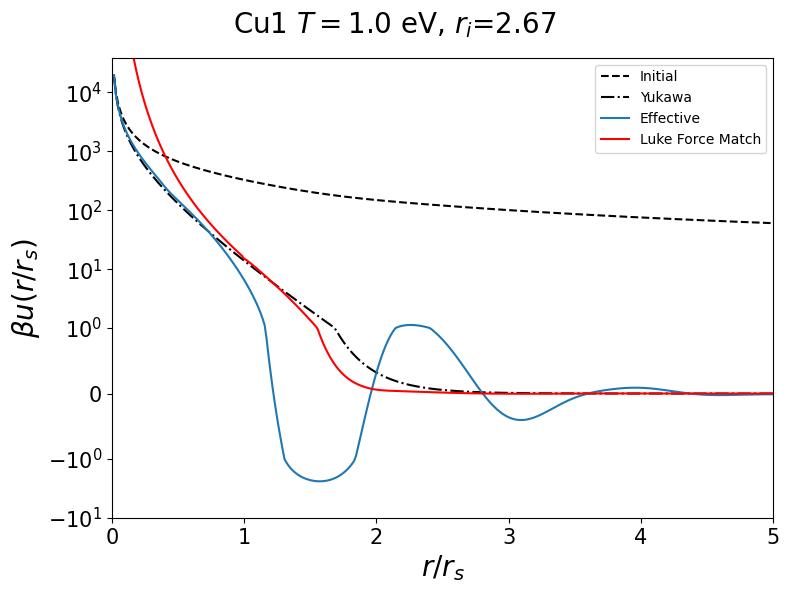

In [190]:
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)


yukawa_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array * np.exp(-atom.r_array*atomqsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(atom.r_array, yukawa_matrix[0,0],'k-.', label="Yukawa")

ax.plot(atom.r_array, atom.βueff_r_matrix[0,0],color=colors[0], label='Effective')    
ax.plot(luke_r, luke_βV,'r-', label='Luke Force Match')

ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(0, 5)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)
fig.tight_layout()